In [1]:
import sample_network_unmix as snu
import export_rate_optimize as ero
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from matplotlib.colors import LogNorm
import time

from typing import Dict, List, Tuple, Any, Callable


def explore_regularisation_strengths(
    export_strength_tryer: Callable[[float], Dict[str, Any]],
    start: float = -4,
    stop: float = 2,
    number: int = 19,
) -> pd.DataFrame:
    """Explore a range of regularisation strengths and plot the results. Takes
    as input a function that maps a regulariser strength to a dictionary of model outputs.
    This requires defining a function for each network which is undesirable but for now it'll do. 
    We parallelise the function calls using multiprocessing.Pool which allows for a number of regulariser strengths 
    to be tried at once. The results are then plotted on a scatter plot of data misfit against model size."""
    export_reg_strengths = list(np.logspace(start, stop, number))
    with Pool(cpu_count()) as pool:
        outputs = pool.map(func=export_strength_tryer, iterable=export_reg_strengths)
    # Process the outputs into a more manageable format
    results_df = pd.DataFrame(
        [
            {
                "regulariser": o["regulariser"],
                "data_misfit": o["data_misfit"],
                "model_size": o["model_size"],
                **o["export_rates"].composition,
            }
            for o in outputs
        ]
    )
    plt.scatter(
        results_df["data_misfit"],
        results_df["model_size"],
        c=results_df["regulariser"],
        norm=LogNorm(),
    )
    plt.xlabel("Data misfit")
    plt.ylabel("Model size")
    # Plot the regulariser strength as a text label
    for i, txt in enumerate(np.log10(results_df["regulariser"])):
        plt.annotate(np.round(txt,2), (results_df["data_misfit"][i], results_df["model_size"][i]))
    cb = plt.colorbar()
    cb.set_label("Regulariser strength")
    plt.show()
    return results_df


def plot_export_rates_against_regulariser(results_df: pd.DataFrame, nodes: List[str], title: str):
    """Plot the export rates for each node against regulariser strength."""
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Regulariser strength")
    plt.ylabel("Export rate")
    plt.xscale("log")
    plt.yscale("logit")
    # Loop through the nodes in the network and plot the export rate against regulariser strength
    for node in nodes:
        plt.plot(
            results_df["regulariser"],
            results_df[node],
            label=node,
        )
    plt.legend()
    
def plot_misfits_against_regstrength(results_df: pd.DataFrame, chosen_strength: float): 
    """Plot the data misfit and model size against regulariser strength."""
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel("Regulariser strength")
    ax1.set_ylabel("Data misfit")
    ax1.set_xscale("log")
    ax1.plot(
        results_df["regulariser"],
        results_df["data_misfit"],
        c='k'
    )    
    ax1.scatter(
        results_df["regulariser"],
        results_df["data_misfit"],
        c='k'
    )
    ax1.legend(["Data misfit"], loc="center left")

    # Add a dashed line showing chosen regularisation strenght extending from minimum data misfit to maximum data misfit
    ax1.vlines(
        x=chosen_strength,
        ymin=min(results_df["data_misfit"]),
        ymax=max(results_df["data_misfit"]),
        color="grey",
        linestyles="dashed",
    )
    ax2 = ax1.twinx()
    ax2.plot(
        results_df["regulariser"],
        results_df["model_size"],
        c='red'
    )    
    ax2.scatter(
        results_df["regulariser"],
        results_df["model_size"],
        c='k'
    )
    # Add a legend to the plot
    ax2.legend(["Model size"], loc="center right")


### Set up the overall sample network and load in the data

In [2]:
# Load sample network
sample_network, _ = snu.get_sample_graphs(
    flowdirs_filename="data/d8.asc",
    sample_data_filename="data/sample_data.dat",
)

# Load in observations
obs_data = pd.read_csv("data/sample_data.dat", delimiter=" ")
obs_data = obs_data.drop(columns=["Bi", "S"])
print("Building problem...")
elements = obs_data.columns[3:-5]
source_regulariser = 10 ** (-1.0)

Building problem...


### Split the network into indidivual networks for each river

In [3]:
# Splitting sample network into one for each river
components = [
    sample_network.subgraph(c).copy() for c in nx.weakly_connected_components(sample_network)
]
river_networks = {}
for c in components:
    root = [n for n in nx.topological_sort(c)][-1]
    if root == "CG039":
        name = "Spey"
    elif root == "CG088":
        name = "Dee"
    elif root == "CG090":
        name = "Deveron"
    elif root == "CG013":
        name = "Tay"
    elif root == "CG021":
        name = "Don"
    river_networks[name] = c


def network_to_problem_multielement(
    river_network: nx.digraph,
) -> Tuple[snu.SampleNetworkUnmixer, ero.MultiElementData]:
    """
    Converts a river network into a SampleNetworkUnmixer problem and a MultiElementData object.
    """
    problem = snu.SampleNetworkUnmixer(sample_network=river_network)
    # Generate a MultiElementData object for each river stored in a dictionary
    samples = [n for n in river_network.nodes]
    obs = obs_data[obs_data["Sample.Code"].isin(samples)]
    multielement = ero.get_multielementdata(obs, elements)
    return problem, multielement

## Deveron

Now we set up the problem in the river Deveron which is small so we can assess the run-time.

Compiling problem...
Exploring regulariser strengths for Deveron...
!! Success !!
{'CG075': 0.055598572381546495, 'CG090': 0.44423459633039153, 'CG037_rep_avg_dup_avg': 0.30799110653287387, 'CG001': 0.08138452897696205, 'CG036': 0.05194749814880029, 'CG031': 0.058843697629425866}
!! Success !!
{'CG075': 0.03743128563603794, 'CG090': 0.5442073712680986, 'CG037_rep_avg_dup_avg': 0.25164443007407694, 'CG001': 0.0841346882536801, 'CG036': 0.028225618356701607, 'CG031': 0.054356606411404884}
!! Success !!
{'CG075': 0.0390574223368184, 'CG090': 0.5379494503167431, 'CG037_rep_avg_dup_avg': 0.2633710232032452, 'CG001': 0.07364646004207763, 'CG036': 0.031251767249265656, 'CG031': 0.05472387685184993}
!! Success !!
{'CG075': 0.052840895490868796, 'CG090': 0.4484730169196077, 'CG037_rep_avg_dup_avg': 0.32792274017816164, 'CG001': 0.06660226262432552, 'CG036': 0.04015127956568433, 'CG031': 0.06400980522135198}
!! Success !!
{'CG075': 0.08173043921092833, 'CG090': 0.27883702671184546, 'CG037_rep_av

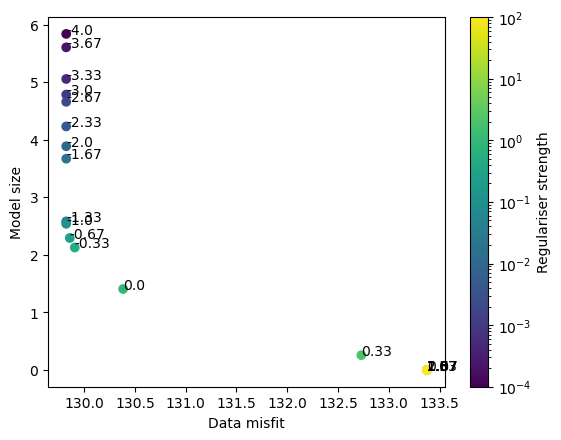

########################################
Analysed results for 19 regulariser strengths
Time taken: 1.4346471031506856 minutes
########################################


In [4]:
deveron_problem, deveron_multielement = network_to_problem_multielement(river_networks["Deveron"])
deveron_nodes = [n for n in river_networks["Deveron"]]
deveron_optimiser = ero.ExportRateOptimizer(
    source_optimiser=deveron_problem,
    observations=deveron_multielement,
    source_regulariser_strength=source_regulariser,
    export_regulariser_strength=0.0,
)


def try_reg_strength_deveron(
    reg_strength: float,
):
    """Try a regulariser strength and return the resulting export rates and data misfit."""
    deveron_optimiser.regulariser_strength = reg_strength
    deveron_optimiser.optimise()
    return {
        "regulariser": reg_strength,
        "export_rates": deveron_optimiser.export_rates,
        "data_misfit": deveron_optimiser.data_misfit,
        "model_size": deveron_optimiser.model_size,
    }


print("Exploring regulariser strengths for Deveron...")
start_time = time.time()

number_to_try = 19
deveron_results = explore_regularisation_strengths(try_reg_strength_deveron, number=number_to_try)
end_time = time.time()
print("#" * 40)
print(f"Analysed results for {number_to_try} regulariser strengths")
print(f"Time taken: {(end_time - start_time)/60} minutes")
print("#" * 40)

### Visualise Deveron results

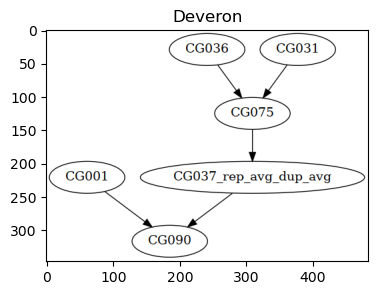

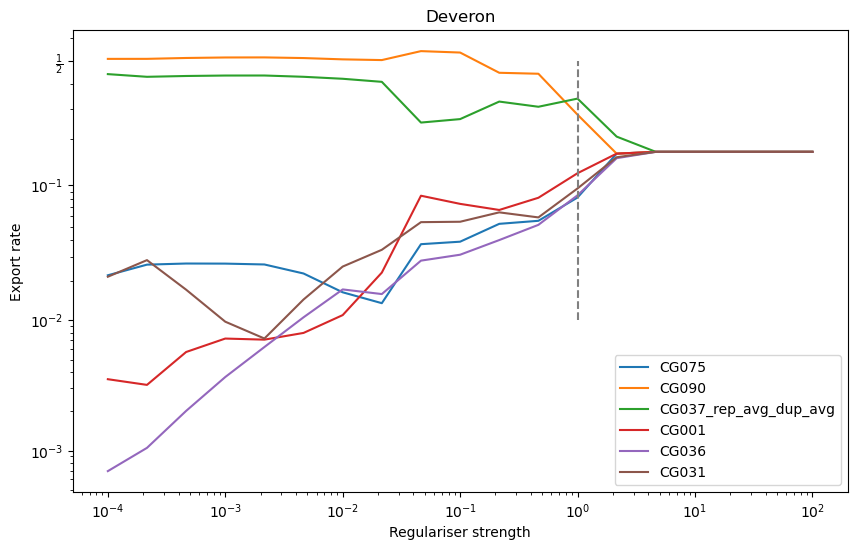

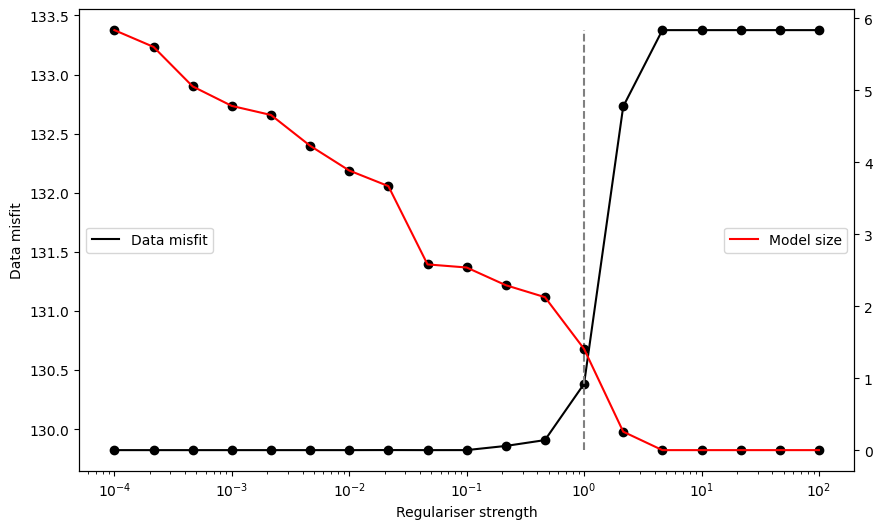

In [5]:
plt.figure(figsize=(5, 3))  # Visualise network
plt.title("Deveron")
snu.plot_network(river_networks["Deveron"])
plt.show()

# Extract entries of "deveron_results" for chosen regulariser strength:
chosen_deveron_strength = 1
chosen_deveron_results = deveron_results[deveron_results["regulariser"] == chosen_deveron_strength]
# Raise an exception if the chosen regulariser strength is not in the results
if len(chosen_deveron_results) == 0:
    raise ValueError(f"Regulariser strength {chosen_deveron_strength} not in results.")
# Get the export rates for the nodes as a dictionary
deveron_export_rates = chosen_deveron_results[deveron_nodes].to_dict("records")[0]

plot_export_rates_against_regulariser(deveron_results, deveron_nodes, "Deveron")
plt.vlines(x=chosen_deveron_strength, ymin=1e-2, ymax=0.5, color="grey", linestyles="dashed")
plt.show()

plot_misfits_against_regstrength(deveron_results, chosen_deveron_strength)
plt.show()

We can see that there is a trade-off between data-misfit and model-size. As we increase the regularisation parameter we go from low-misfit and high model-size to high-misfit and low model-size. At a regularisation parameter of $10^0$ we have a good balance between the two so we choose this as our trade-off. At the very small regulariser strengths we go from essentially a perfect fit, but as we increase the strength the export rates all tend to the equal value. This is the 'base' assumption from the original model. 

Unfortunately we seem to observe that there is a strong impact of network strucutre on the results. The most downstream nodes seem to have higher export rates. This can be understood based on the fact that when the downstream node export-rate rises very high, the observed downstream composition will depend *only* on the concentration of that node. As a result, it can easily be over-fit, and it will have no impact on any other nodes. This is a problem with the model structure, and we will need to think about how to address this, if it is possible. This effect will be true, to a lesser extent, for all nodes, but it will be most pronounced for the most downstream nodes. 

We can also understand the tendency to make leaf-nodes have an extremely low export rate. When a leaf-node is set to have a very low export-rate, the concentration of the source node can be adjusted to have exactly the same composition as the observed composition. But, when the export rate is very low, the concentration of the source node will have very little impact on the downstream nodes. This means that the source node can be adjusted to have any composition, and it will have very little impact on the downstream nodes. Therefore, there is a tendency to massively increase the export rate of downstream nodes (to drown out any other contributions and overfit these data) but for upstream nodes there is a tendency to massively decrease the export rate (to allow the downstream nodes to be overfit). 


## Spey 

Compiling problem...
Exploring regulariser strengths for Spey...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  war


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 



/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 



/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 



/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 



/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 



/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 



/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solv

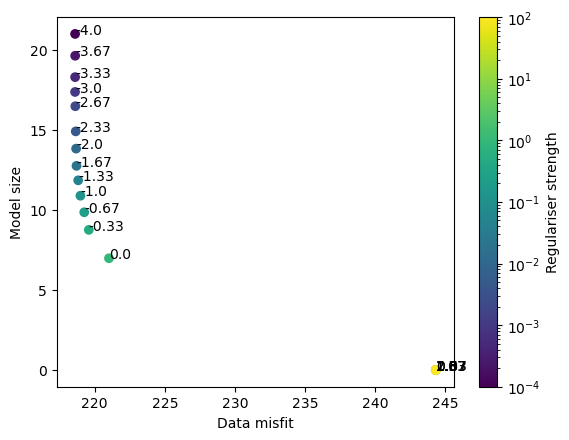

########################################
Analysed results for 19 regulariser strengths
Time taken: 10.21819727420807 minutes
########################################


In [6]:
spey_problem, spey_multielement = network_to_problem_multielement(river_networks["Spey"])
spey_nodes = [n for n in river_networks["Spey"]]
spey_optimiser = ero.ExportRateOptimizer(
    source_optimiser=spey_problem,
    observations=spey_multielement,
    source_regulariser_strength=source_regulariser,
    export_regulariser_strength=0.0,
)


def try_reg_strength_spey(
    reg_strength: float,
):
    """Try a regulariser strength and return the resulting export rates and data misfit."""
    spey_optimiser.regulariser_strength = reg_strength
    spey_optimiser.optimise()
    return {
        "regulariser": reg_strength,
        "export_rates": spey_optimiser.export_rates,
        "data_misfit": spey_optimiser.data_misfit,
        "model_size": spey_optimiser.model_size,
    }


print("Exploring regulariser strengths for Spey...")
start_time = time.time()

number_to_try = 19
spey_results = explore_regularisation_strengths(try_reg_strength_spey, number=number_to_try)
end_time = time.time()
print("#" * 40)
print(f"Analysed results for {number_to_try} regulariser strengths")
print(f"Time taken: {(end_time - start_time)/60} minutes")
print("#" * 40)

### Visualise Spey Results

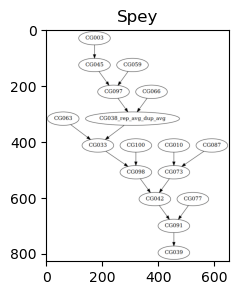

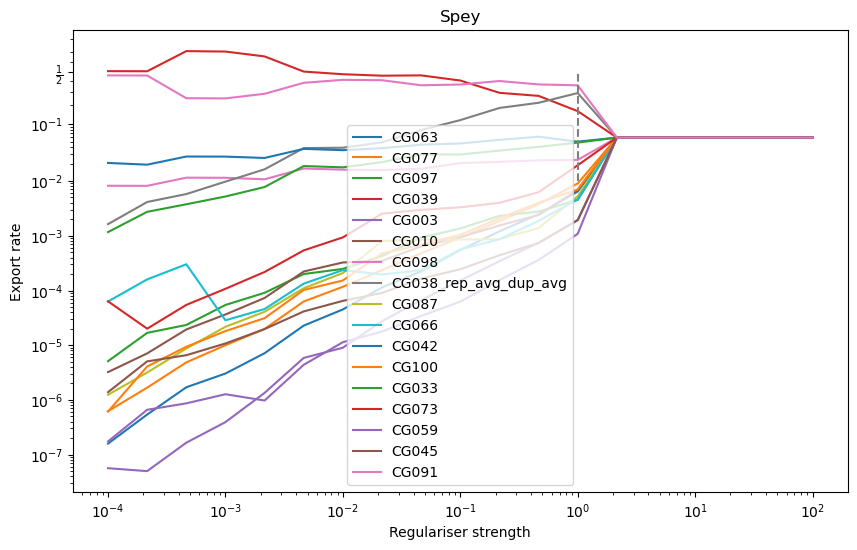

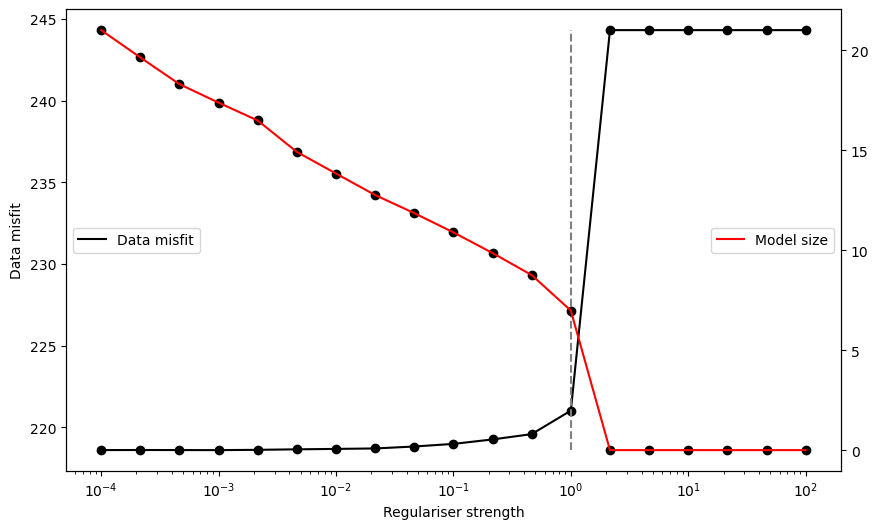

In [7]:
plt.figure(figsize=(5, 3))  # Visualise network
plt.title("Spey")
snu.plot_network(river_networks["Spey"])
plt.show()

# Extract entries of "spey_results" for chosen regulariser strength:
chosen_spey_strength = 1
chosen_spey_results = spey_results[spey_results["regulariser"] == chosen_spey_strength]
# Raise an exception if the chosen regulariser strength is not in the results
if len(chosen_spey_results) == 0:
    raise ValueError(f"Regulariser strength {chosen_spey_strength} not in results.")
# Get the export rates for the nodes as a dictionary
spey_export_rates = chosen_spey_results[spey_nodes].to_dict("records")[0]

plot_export_rates_against_regulariser(spey_results, spey_nodes, "Spey")
plt.vlines(x=chosen_spey_strength, ymin=1e-2, ymax=0.5, color="grey", linestyles="dashed")
plt.show()

plot_misfits_against_regstrength(spey_results, chosen_spey_strength)
plt.show()

## Don

Compiling problem...
Exploring regulariser strengths for Don...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  war


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 



/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solv

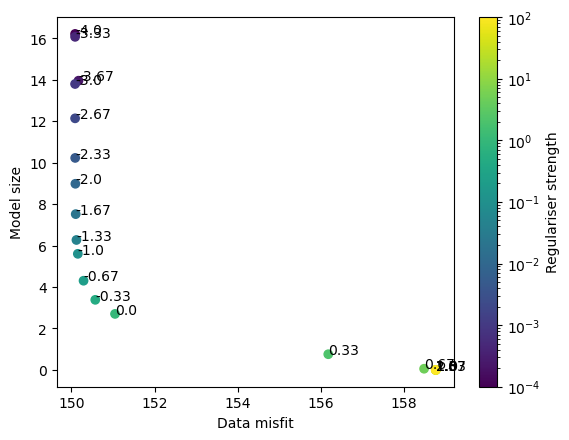

########################################
Analysed results for 19 regulariser strengths
Time taken: 2.6056800365447996 minutes
########################################


In [8]:
don_problem, don_multielement = network_to_problem_multielement(river_networks["Don"])
don_nodes = [n for n in river_networks["Don"]]
don_optimiser = ero.ExportRateOptimizer(
    source_optimiser=don_problem,
    observations=don_multielement,
    source_regulariser_strength=source_regulariser,
    export_regulariser_strength=0.0,
)

def try_reg_strength_don(
    reg_strength: float,
):
    """Try a regulariser strength and return the resulting export rates and data misfit."""
    don_optimiser.regulariser_strength = reg_strength
    don_optimiser.optimise()
    return {
        "regulariser": reg_strength,
        "export_rates": don_optimiser.export_rates,
        "data_misfit": don_optimiser.data_misfit,
        "model_size": don_optimiser.model_size,
    }


print("Exploring regulariser strengths for Don...")
start_time = time.time()

number_to_try = 19
don_results = explore_regularisation_strengths(try_reg_strength_don, number=number_to_try)
end_time = time.time()
print("#" * 40)
print(f"Analysed results for {number_to_try} regulariser strengths")
print(f"Time taken: {(end_time - start_time)/60} minutes")
print("#" * 40)

### Visualise Don Results

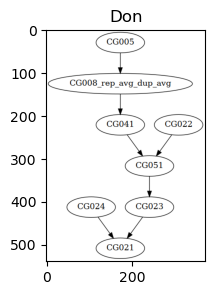

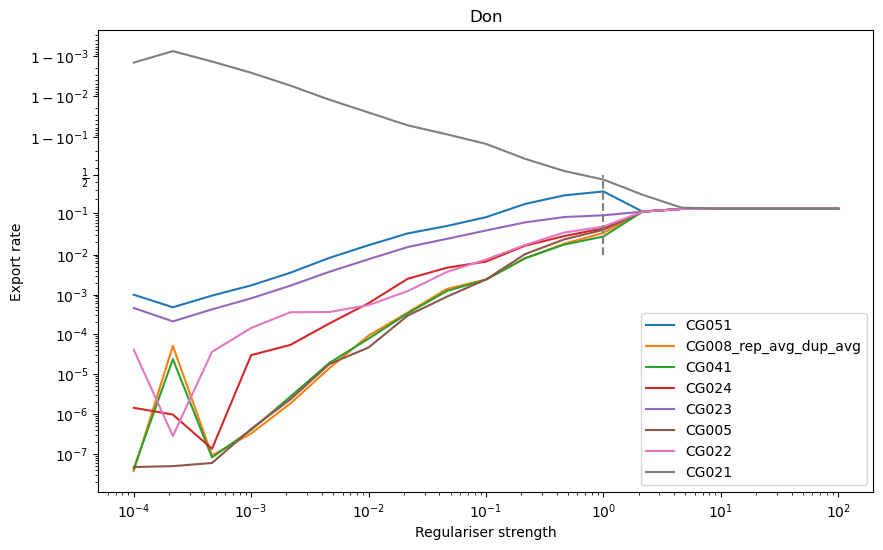

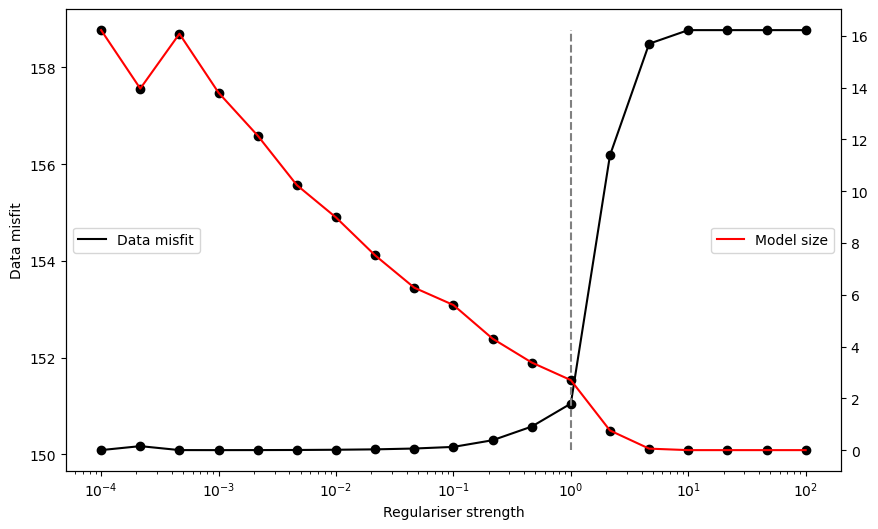

In [11]:
plt.figure(figsize=(5, 3))  # Visualise network
plt.title("Don")
snu.plot_network(river_networks["Don"])
plt.show()

# Extract entries of "don_results" for chosen regulariser strength:
chosen_don_strength = 1
chosen_don_results = don_results[don_results["regulariser"] == chosen_don_strength]
# Raise an exception if the chosen regulariser strength is not in the results
if len(chosen_don_results) == 0:
    raise ValueError(f"Regulariser strength {chosen_don_strength} not in results.")
# Get the export rates for the nodes as a dictionary
don_export_rates = chosen_don_results[don_nodes].to_dict("records")[0]

plot_export_rates_against_regulariser(don_results, don_nodes, "Don")
plt.vlines(x=chosen_don_strength, ymin=1e-2, ymax=0.5, color="grey", linestyles="dashed")
plt.show()

plot_misfits_against_regstrength(don_results, chosen_don_strength)
plt.show()

These results are much the same as for the others. We see a clear trade-off between model-size and data-misfit. Additionally we also observe the clear dependency of results on position in the network. 

## Tay

In [ ]:
tay_problem, tay_multielement = network_to_problem_multielement(river_networks["Tay"])
tay_nodes = [n for n in river_networks["Tay"]]
tay_optimiser = ero.ExportRateOptimizer(
    source_optimiser=tay_problem,
    observations=tay_multielement,
    source_regulariser_strength=source_regulariser,
    export_regulariser_strength=0.0,
)

def try_reg_strength_tay(
    reg_strength: float,
):
    """Try a regulariser strength and return the resulting export rates and data misfit."""
    tay_optimiser.regulariser_strength = reg_strength
    tay_optimiser.optimise()
    return {
        "regulariser": reg_strength,
        "export_rates": tay_optimiser.export_rates,
        "data_misfit": tay_optimiser.data_misfit,
        "model_size": tay_optimiser.model_size,
    }


print("Exploring regulariser strengths for Tay...")
start_time = time.time()

number_to_try = 1
tay_results = explore_regularisation_strengths(try_reg_strength_tay, number=number_to_try)
end_time = time.time()
print("#" * 40)
print(f"Analysed results for {number_to_try} regulariser strengths")
print(f"Time taken: {(end_time - start_time)/60} minutes")
print("#" * 40)

In [ ]:
tay_optimiser.source_regulariser_strength = 10 ** (-1.0)
tay_optimiser.export_regulariser_strength = 1
start_time = time.time()
tay_optimiser.optimise()
end_time = time.time()
print("#" * 40)
print(f"Optimised results for Tay")
print(f"Time taken: {(end_time - start_time)/60} minutes")
print("#" * 40)

### Visualise Tay Results

In [ ]:
plt.figure(figsize=(5, 3))  # Visualise network
plt.title("Tay")
snu.plot_network(river_networks["Tay"])
plt.show()

# Extract entries of "tay_results" for chosen regulariser strength:
chosen_tay_strength = 1
chosen_tay_results = tay_results[tay_results["regulariser"] == chosen_tay_strength]
# Raise an exception if the chosen regulariser strength is not in the results
if len(chosen_tay_results) == 0:
    raise ValueError(f"Regulariser strength {chosen_tay_strength} not in results.")
# Get the export rates for the nodes as a dictionary
tay_export_rates = chosen_tay_results[tay_nodes].to_dict("records")[0]

plot_export_rates_against_regulariser(tay_results, tay_nodes, "Tay")
plt.vlines(x=chosen_tay_strength, ymin=1e-2, ymax=0.5, color="grey", linestyles="dashed")
plt.show()

plot_misfits_against_regstrength(tay_results, chosen_tay_strength)
plt.show()

## Dee

Compiling problem...
Exploring regulariser strengths for Dee...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 



/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  war


 ECOS solver failed, trying again with SCS solver... 



/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



 ECOS solver failed, trying again with SCS solver... 



/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 


 ECOS solver failed, trying again with SCS solver... 



/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


!! Success !!
{'CG020': 0.06623246491746326, 'CG032': 0.028264267927766838, 'CG061': 0.009808133567642978, 'CG086_rep_avg_dup_avg': 0.13880102464977875, 'CG065': 0.01989187965085614, 'CG025': 0.02576163853263954, 'CG093': 0.033168543314851424, 'CG062': 0.04146323882809419, 'CG044': 0.031715550438669485, 'CG064': 0.07169135094237716, 'CG084': 0.04745779061393241, 'CG057': 0.03065323863660839, 'CG088': 0.43102578018211385, 'CG002': 0.02406509779720572}
!! Success !!
{'CG020': 0.014545047736552024, 'CG032': 0.004672429773283403, 'CG061': 0.00015639722580826321, 'CG086_rep_avg_dup_avg': 0.20471113494273252, 'CG065': 0.0007825873002321103, 'CG025': 0.001092977483591256, 'CG093': 0.002019023113235458, 'CG062': 0.004649943371645471, 'CG044': 0.0034492069848314107, 'CG064': 0.014021897667764719, 'CG084': 0.018448933619895323, 'CG057': 0.0017625725825279738, 'CG088': 0.7254862370805092, 'CG002': 0.004201611117390894}
!! Success !!
{'CG020': 0.023673358851202708, 'CG032': 0.006823238738997928, '

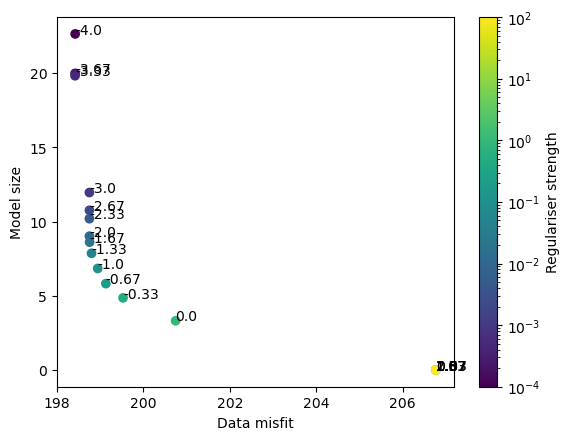

########################################
Analysed results for 19 regulariser strengths
Time taken: 7.2190426111221315 minutes
########################################


In [9]:
dee_problem, dee_multielement = network_to_problem_multielement(river_networks["Dee"])
dee_nodes = [n for n in river_networks["Dee"]]
dee_optimiser = ero.ExportRateOptimizer(
    source_optimiser=dee_problem,
    observations=dee_multielement,
    source_regulariser_strength=source_regulariser,
    export_regulariser_strength=0.0,
)

def try_reg_strength_dee(
    reg_strength: float,
):
    """Try a regulariser strength and return the resulting export rates and data misfit."""
    dee_optimiser.regulariser_strength = reg_strength
    dee_optimiser.optimise()
    return {
        "regulariser": reg_strength,
        "export_rates": dee_optimiser.export_rates,
        "data_misfit": dee_optimiser.data_misfit,
        "model_size": dee_optimiser.model_size,
    }


print("Exploring regulariser strengths for Dee...")
start_time = time.time()

number_to_try = 19
dee_results = explore_regularisation_strengths(try_reg_strength_dee, number=number_to_try)
end_time = time.time()
print("#" * 40)
print(f"Analysed results for {number_to_try} regulariser strengths")
print(f"Time taken: {(end_time - start_time)/60} minutes")
print("#" * 40)

### Visualise Dee Results

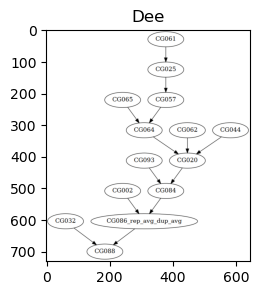

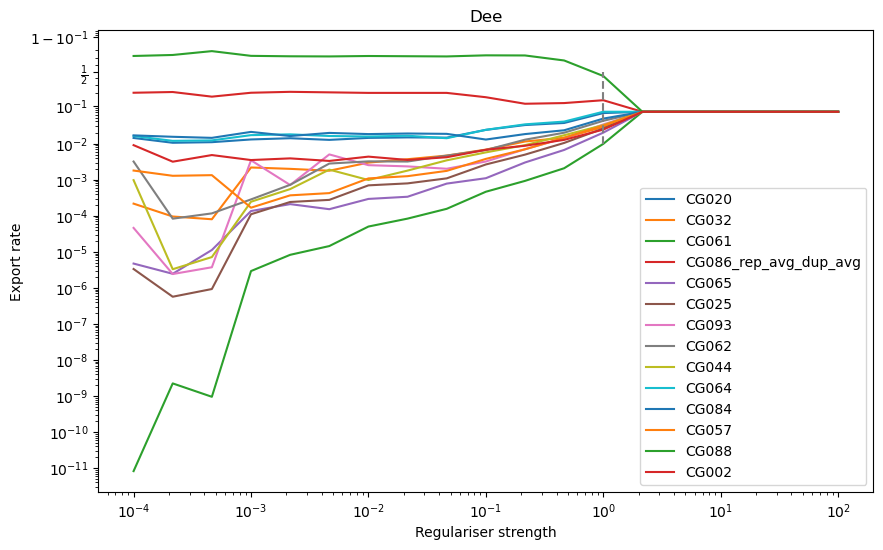

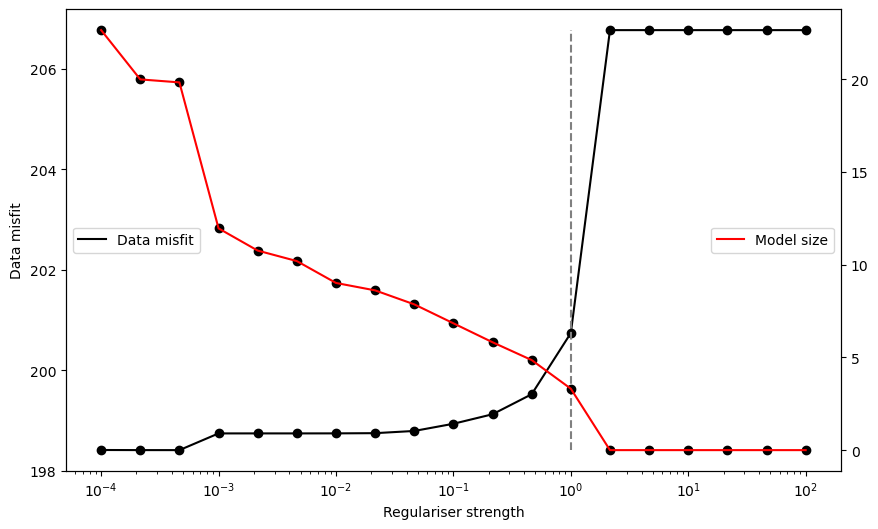

In [10]:
plt.figure(figsize=(5, 3))  # Visualise network
plt.title("Dee")
snu.plot_network(river_networks["Dee"])
plt.show()

# Extract entries of "dee_results" for chosen regulariser strength:
chosen_dee_strength = 1
chosen_dee_results = dee_results[dee_results["regulariser"] == chosen_dee_strength]
# Raise an exception if the chosen regulariser strength is not in the results
if len(chosen_dee_results) == 0:
    raise ValueError(f"Regulariser strength {chosen_dee_strength} not in results.")
# Get the export rates for the nodes as a dictionary
dee_export_rates = chosen_dee_results[dee_nodes].to_dict("records")[0]

plot_export_rates_against_regulariser(dee_results, dee_nodes, "Dee")
plt.vlines(x=chosen_dee_strength, ymin=1e-2, ymax=0.5, color="grey", linestyles="dashed")
plt.show()

plot_misfits_against_regstrength(dee_results, chosen_dee_strength)
plt.show()

## Visualising results

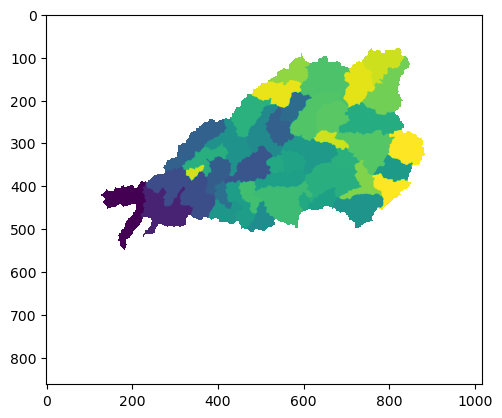

In [29]:
tay_nodes = [n for n in river_networks["Tay"]]
tay_export_rates = {n : np.nan for n in tay_nodes}

all_export_rates = {
    **deveron_export_rates,
    **spey_export_rates,
    **don_export_rates,
    **tay_export_rates,
    **dee_export_rates,
}

rltv_export_rate_map = snu.get_upstream_concentration_map(area_dict,all_export_rates)
rltv_export_rate_map[rltv_export_rate_map==0] = np.nan 
plt.imshow(rltv_export_rate_map, cmap="viridis", norm=LogNorm())

We could not get achieve a stable result for the Tay so just use 'nan' values here but visualise the rest. The results here highlight the strong overprinting of network structure onto the calculate export rates. We would expert upstream regions (which contain steeper terrain) to have higher export rates but instead the sub-basins close to the mouth have highest export rates, which is highly unintuitive. As a result, it seems unlikely that at present this approach will be able to provide a useful estimate of export rates.

## Converting relative values into absolute rates

In [21]:
# For each node we now multiply the relative export rate by the area to get a relative flux from each sub-basin
# The sum of all sub-basins can then be compared to the observed total sediment flux from the river.
# By dividing the two, we can get the multiplier with which we can multiply the relative export rates to get the absolute export rate from each sub-basin.
area_dict = snu.get_unique_upstream_areas(sample_network)

def get_relative_fluxes(
    export_rates: Dict[str, float], area_dict: Dict[str, float]
) -> Dict[str, float]:
    """Get the relative fluxes from each sub-basin."""
    relative_fluxes = {}
    for node in export_rates:
        relative_fluxes[node] = export_rates[node] * area_dict[node]
    return relative_fluxes


def convert_rltv_to_abs_export_rates(
    rltv_export_rates: Dict[str, float], multiplier: float
) -> Dict[str, float]:
    """Convert relative export rates to absolute export rates."""
    return {node: rate * multiplier for node, rate in rltv_export_rates.items()}


spey_relative_fluxes = get_relative_fluxes(spey_export_rates, area_dict)
total_spey_flux = sum(spey_relative_fluxes.values())
deveron_relative_fluxes = get_relative_fluxes(deveron_export_rates, area_dict)
total_deveron_flux = sum(deveron_relative_fluxes.values())
don_relative_fluxes = get_relative_fluxes(don_export_rates, area_dict)
total_don_flux = sum(don_relative_fluxes.values())
tay_relative_fluxes = get_relative_fluxes(tay_export_rates, area_dict)
total_tay_flux = sum(tay_relative_fluxes.values())
dee_relative_fluxes = get_relative_fluxes(dee_export_rates, area_dict)
total_dee_flux = sum(dee_relative_fluxes.values())

observed_spey_flux = 0.03  # PLACEHOLDER Mt/year
observed_deveron_flux = 0.01  # Mt/year - Milliman & Farnsworth (2011)
observed_don_flux = 0.03  # Mt/year - Milliman & Farnsworth (2011)
observed_tay_flux = 0.5  # PLACEHOLDER Mt/year
observed_dee_flux = 0.03  # Mt/year - Milliman & Farnsworth (2011)

deveron_multiplier = observed_deveron_flux / total_deveron_flux
don_multiplier = observed_don_flux / total_don_flux
dee_multiplier = observed_dee_flux / total_dee_flux
tay_multiplier = observed_tay_flux / total_tay_flux
spey_multiplier = observed_spey_flux / total_spey_flux

deveron_abs_export_rates = convert_rltv_to_abs_export_rates(
    deveron_relative_fluxes, deveron_multiplier
)
don_abs_export_rates = convert_rltv_to_abs_export_rates(don_relative_fluxes, don_multiplier)
dee_abs_export_rates = convert_rltv_to_abs_export_rates(dee_relative_fluxes, dee_multiplier)
tay_abs_export_rates = convert_rltv_to_abs_export_rates(tay_relative_fluxes, tay_multiplier)
spey_abs_export_rates = convert_rltv_to_abs_export_rates(spey_relative_fluxes, spey_multiplier)

/tmp/ipykernel_137606/1497851206.py:40: RuntimeWarning: divide by zero encountered in divide
  deveron_multiplier = observed_deveron_flux / total_deveron_flux
/tmp/ipykernel_137606/1497851206.py:41: RuntimeWarning: divide by zero encountered in divide
  don_multiplier = observed_don_flux / total_don_flux
/tmp/ipykernel_137606/1497851206.py:42: RuntimeWarning: divide by zero encountered in divide
  dee_multiplier = observed_dee_flux / total_dee_flux
/tmp/ipykernel_137606/1497851206.py:44: RuntimeWarning: divide by zero encountered in divide
  spey_multiplier = observed_spey_flux / total_spey_flux
/tmp/ipykernel_137606/1497851206.py:20: RuntimeWarning: invalid value encountered in multiply
  return {node: rate * multiplier for node, rate in rltv_export_rates.items()}


## Exploring all the export rates together

In [23]:
# Combining all the export rates into one dictionary
all_abs_export_rates = (
    spey_abs_export_rates
    | don_abs_export_rates
    | deveron_abs_export_rates
    | tay_abs_export_rates
    | dee_abs_export_rates
)

all_abs_export_rates
# export_map = snu.get_upstream_concentration_map(
#     areas=area_dict, upstream_preds=all_abs_export_rates
# )
# export_map[export_map == 0] = np.nan
# plt.imshow(export_map, norm=LogNorm(), cmap="viridis"())
# plt.colorbar()
# plt.show()

{'CG063': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'CG077': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'CG097': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'CG039': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, 

## Comparing relative flux sizes to topographic metrics in each basin 

Now we compare, for each sub-basin, the relatioship between calculated sediment flux and various topographic metrics including average slope and average elevation. 